## SuperResolution

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn

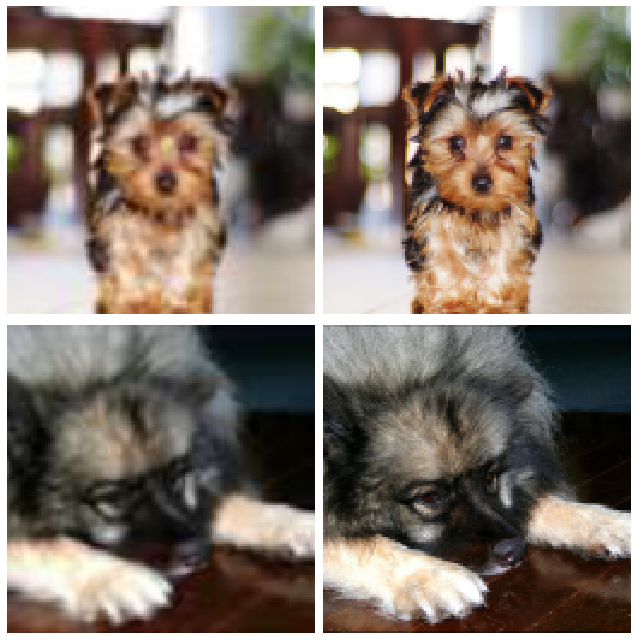

In [2]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

il = ImageList.from_folder(path_hr)

def resize_one(fn, i):
    dest = path_lr / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)
parallel(resize_one, il.items, max_workers=1)

bs, size = 32, 128
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr / x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

data = get_data(bs, size)
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Feature loss

In [3]:
t = data.valid_ds[0][1].data
t = torch.stack([t, t])

def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2) / (c*h*w))
gram_matrix(t)

tensor([[[0.1402, 0.1265, 0.1157],
         [0.1265, 0.1164, 0.1078],
         [0.1157, 0.1078, 0.1017]],

        [[0.1402, 0.1265, 0.1157],
         [0.1265, 0.1164, 0.1078],
         [0.1157, 0.1078, 0.1017]]])

In [4]:
bass_loss = F.l1_loss
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [5]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))] + [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_loss = [base_loss(input, target)]
        self.feat_loss += [base_loss(f_in, f_out)*w for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_loss += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2*5e3 for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self):
        self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5, 15, 2])

### Train

In [6]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)

gc.collect()

learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 198.00 MiB (GPU 0; 6.00 GiB total capacity; 1.75 GiB already allocated; 133.55 MiB free; 45.68 MiB cached)

In [ ]:
lr = 1e-3

def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)
    
do_fit('la', slice(lr*10))

In [ ]:
learn.unfreeze()
do_fit('lb', slice(1e-5, 1e-3))

In [ ]:
data = get_data(bs//2, size*2)
learn.data = data
learn.freeze()
do_fit('2a')

In [ ]:
learn.unfreeze()
do_fit('2b', slice(1e-6, 1e-4), pct_start=0.3)

### Test

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=(819, 1024), tfm_y=True)
          .databunch(bs=2).normalize(imagenet_stats, do_y=True))
learn.data = data_mr
fn = data_mr.valid_ds.x.items[0]
fn

In [ ]:
img = open_image(fn)
img.shape

In [ ]:
_, img_hr, b = learn.predict(img)
show_image(img, figsize(18, 15), interpolation='nearest')